In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random as rn

## Tarea: Modelo climático

### Problema

La probabilidad de que llueva (en Bogotá) crece linealmente desde cero a partir de las 6 am hasta tomar su máximo
a las 2 pm. Luego decrece hasta llegar a cero a las 6 pm.

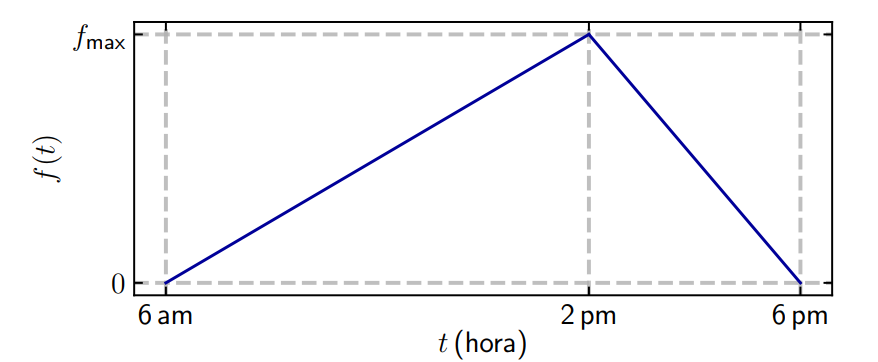

### Preguntas

#### 1. **Densidad de probabilidad**
Resolvemos primero el máximo para este problema utilizando geometría.

$$\text{area} = \frac{12 f_{max}}{2} = 1 \quad \Leftrightarrow \quad f_{max} = \frac{1}{6}$$

Luego, definimos esta función $P$ de *pdf* como:

$$P(x) = \left\{ \begin{array}{lcc} 0 & si & x < 6 \\  (1/48) x - (3/24) & si & 6 \leq x \leq 14 \\  -(1/24) x + (3/4) & si & 14 < x \leq 18 \\  0 & si & x > 18 \end{array} \right. $$

Se define el objeto `prob_lluvia(periodo)` para definir un estado general de lo relacionado con el problema, tanto su *pdf* con `P(x)`, las funciones que definen la probabilidad `.integral(hora)` y `.promedio(hora)`.

In [17]:
class prob_lluvia:
    """"Clase que define las probabilidades según conveniencia e inicializa los valores"""
    def __init__(self, periodo):
        """Se inicializan las variables y se establece la particion x_vals.
        El periodo debe entrar lo mejor posible en el rango."""
        self.periodo = periodo
        self.empieza = 6
        self.termina = 18
        self.f_max = 1/6

        # particion
        self.particion = int((self.termina - self.empieza) / self.periodo) + 1
        self.x_vals = np.linspace(self.empieza, self.termina, num=self.particion)

    def P(self, x):
        """Función de densidad de probabilidad."""
        if x < 6:
            return 0
        elif 6 <= x <= 14:
            return (1/48) * x - (3/24)
        elif 14 < x <= 18:
            return -(1/24) * x + (3/4)
        elif x > 18:
            return 0

    def floor(self, hora):
        for x in self.x_vals:
            if hora >= x and hora < (x + self.periodo) and not(np.isclose(hora, x + self.periodo, atol=1e-4)): return x
        return 0

    def integral(self, hora):
        '''Toma la hora absoluta (0-24 horas) y devuelve la probabilidad 
        como el area en el periodo de la función discretizada'''
        if hora < self.empieza or hora > self.termina: return 0
        hora = self.floor(hora)
        return self.periodo * (np.max([self.P(hora), self.P(hora + self.periodo)]) + np.min([self.P(hora), self.P(hora + self.periodo)])) / 2
    
    def promedio(self, hora):
        '''Toma la hora absoluta (0-24 horas) y devuelve la probabilidad 
        como media entre la función discretizada por el periodo.'''
        if hora < self.empieza or hora > self.termina: return 0
        hora = self.floor(hora)
        return np.abs(self.P(hora + self.periodo) + self.P(hora))/2

# Algunas comprobaciones
pl1 = prob_lluvia(periodo = 0.1)
print(f"""
      Probabilidad: {pl1.integral(8.7)} 
      Probabilidad total promedio: {np.sum([pl1.promedio( hora ) for hora in np.arange(6, 18)]):.4f}
      Probabilidad total integral: {np.sum([pl1.integral( hora ) for hora in np.arange(6, 18)]):.4f}
""")

#Diferencias
list([pl1.integral(hora) - pl1.promedio(hora) for hora in np.arange(6, 18)])


      Probabilidad: 0.005729166666666664 
      Probabilidad total promedio: 1.0000
      Probabilidad total integral: 0.1000



[-0.0009374999999999967,
 -0.01968749999999998,
 -0.038437499999999986,
 -0.057187499999999995,
 -0.07593749999999998,
 -0.09468749999999998,
 -0.1134375,
 -0.13218749999999999,
 -0.14812500000000003,
 -0.110625,
 -0.073125,
 -0.035625000000000025]

Se comprueba entonces que:
- Las funciones de probabilidad están normalizadas a 1.
- Las diferencias entre las formas de tomar la probabilidad son despreciables.

#### 2. **Obtener $f_{max}$**
Cómo se indicó en el punto previo, se resolvió tomando geométricamente el área y resolviendo el punto máximo para que la función de probabilidad fuera normalizada a 1. Como se sugiere también, dado que $f_{max}$ es el carácter que provee a la función la normalizacion, que se pueda generalizar como:

$$\text{area} = \frac{12 f_{max}}{2} = N \quad \Leftrightarrow \quad f_{max} = \frac{N}{6}$$

Luego, definimos esta función $P$ de *pdf* como:

$$P(x) = \left\{ \begin{array}{lcc} 0 & si & x < 6 \\  f_{max}((1/8) x - (3/4)) & si & 6 \leq x \leq 14 \\  f_{max}(-(1/4) x + (9/2)) & si & 14 < x \leq 18 \\  0 & si & x > 18 \end{array} \right. $$

Podemos despejar la normalización para tenerla como parámetro en nuestro objeto `prob_lluvia` y de esa manera generalizarlo aún más.

#### 3. Gráficas y Función Acumulativa

Se gráfica primero la función de probabilidad:

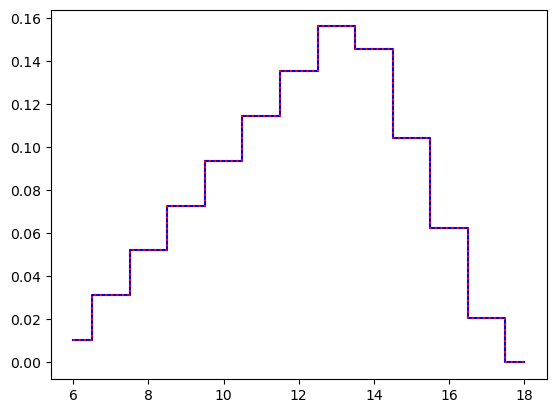

In [28]:
pl2 = prob_lluvia(1)
y_vals = [pl2.promedio(horas) for horas in pl2.x_vals]
y_vals2 = [pl2.integral(horas) for horas in pl2.x_vals]
x_vals = pl2.x_vals
len(y_vals), len(x_vals)
plt.plot(x_vals, y_vals, ds="steps-mid", color="blue")
plt.plot(x_vals, y_vals2, ds="steps-mid", linestyle="dotted", color="red")